First we need to include the coldatoms library

In [1]:
import coldatoms

The cold atoms framework heavily relies on numpy to represent all kinds of data. For example particle positions and momenta. So lets include that as well:

In [2]:
import numpy as np

We'll also import matplotlib so we can plot a few things.

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt

So now lets consider a bunch of particles distributed according to a Gaussian density distribution and a Maxwell-Boltzmann velocity distribution.

In [24]:
positions = np.random.normal(size=(1000, 3))
momenta = np.random.normal(size=positions.shape)

If we let these particles evolve without any forces being applied to them we get ballistic expansion. The following figure shows the initial density distribution.

<IPython.core.display.Javascript object>


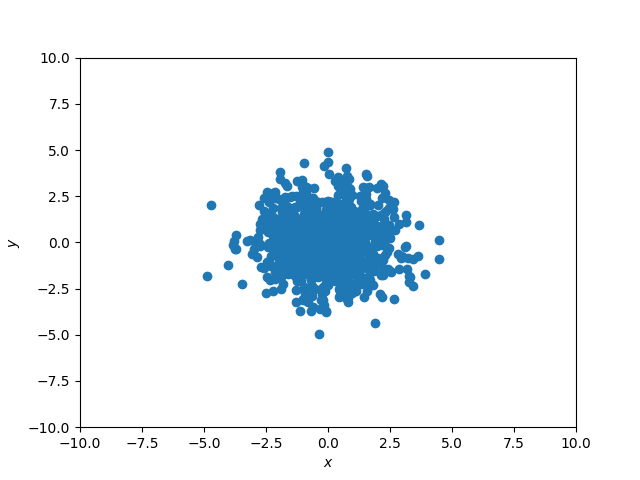

In [27]:
plt.plot(positions[:,0], positions[:,1],'o')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Here is the density distribution after one time step.

<IPython.core.display.Javascript object>


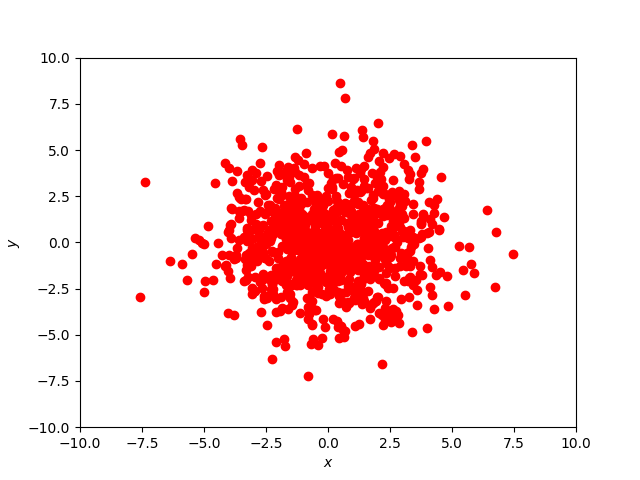

In [28]:
plt.figure()
coldatoms.push(1.0, positions, momenta)
plt.plot(positions[:,0], positions[:,1],'or')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

And here after two time steps

<IPython.core.display.Javascript object>


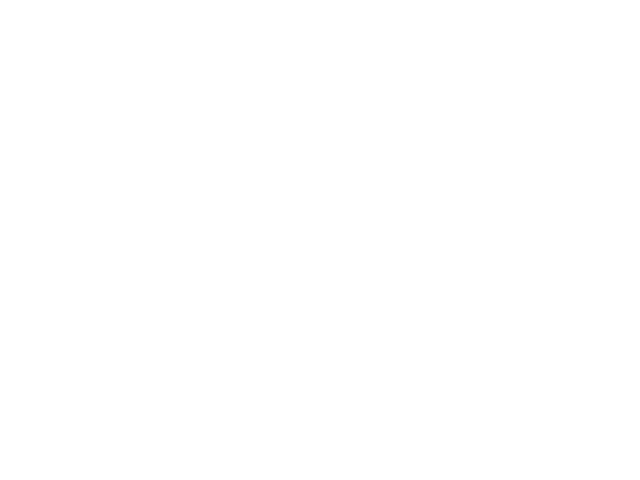

In [29]:
plt.figure()
coldatoms.push(1.0, positions, momenta)
plt.plot(positions[:,0], positions[:,1],'og')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# Some basic performance estimates

In [39]:
import time

In [58]:
def time_ballistic(n):
    positions = np.random.normal(size=(n, 3))
    momenta = np.random.normal(size=positions.shape)
    t = time.time()
    num_iter = 10
    for i in range(num_iter):
        coldatoms.push(0.1, positions, momenta)
    elapsed = time.time() - t
    return elapsed / num_iter

In [41]:
time_ballistic(1000000)

(1000000, 3)


0.07668304443359375

In [42]:
def flops(n):
    return 2 * 2 * n * 3

In [49]:
import math

In [59]:
nptcls = [1000*1.5**e for e in range(0, 20)]
gflops = [flops(n)/time_ballistic(math.floor(n))/(2.0**30) for n in nptcls]

<IPython.core.display.Javascript object>


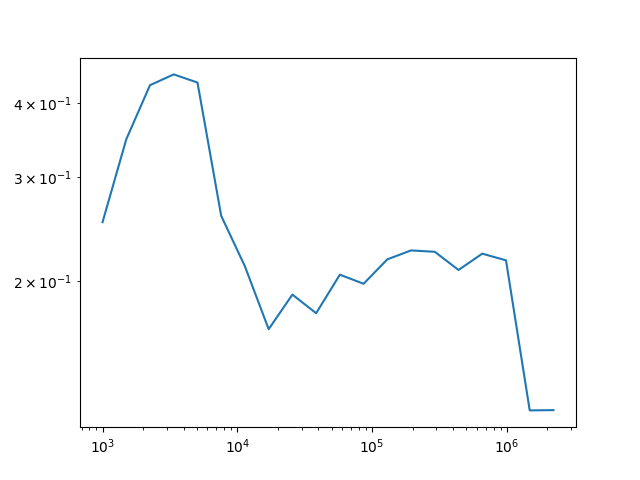

In [60]:
plt.figure()
plt.loglog(nptcls,gflops)